In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [67]:
def process_image(image_path, output_txt):
    # Open image and convert to grayscale
    img = Image.open(image_path).convert("L")
    
    # Resize to 512x512 if not already
    img = img.resize((512, 512))
    
    # Display the grayscale image
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()
    
    # Convert image to numpy array
    pixel_data = np.array(img)
    
    # Save pixel values to text file
    with open(output_txt, "w") as f:
        for row in pixel_data:
            for pixel in row:
                f.write(f"{pixel}\n")
    
    print(f"Pixel data saved to {output_txt}")
    return pixel_data



def normalize_and_display(final_result, window_size):

    
    normalized_data = final_result / window_size**2
    normalized_data = np.clip(normalized_data, 0, 255)
    normalized_image = normalized_data.astype(np.uint8)
    

    plt.imshow(normalized_image, cmap="gray")
    plt.axis("off")  
    plt.show()
    
    return normalized_image

def compute_integral_image(img_array):
    """Computes the integral image of the given grayscale image array."""
    return np.cumsum(np.cumsum(img_array, axis=0), axis=1)



def read_print_fpga(input_txt,wid,hei,window):


    width = wid-window+1
    heigth = hei-window+1
    # Read pixel values from file
    with open(input_txt, "r") as f:
        pixel_values = [int(line.strip()) for line in f]

    # Convert to numpy array and reshape to given dimensions
    pixel_data = np.array(pixel_values, dtype=np.uint32).reshape((heigth, width))

    # Display the grayscale image
    baska = (pixel_data / window**2).astype(np.uint8)
    plt.imshow(baska, cmap="gray")
    plt.axis("off")
    plt.show()
    return baska

def boxfilter(imSrc, r):
    hei, wid = imSrc.shape
    imDst = np.zeros_like(imSrc)

    # Cumulative sum over the Y axis
    imCum = np.cumsum(imSrc, axis=0)

    # Difference over the Y axis with normalization
    imDst[:r+1, :] = imCum[r:2*r+1, :] / (r+1)
    imDst[r+1:hei-r, :] = (imCum[2*r+1:hei, :] - imCum[:hei-2*r-1, :]) / (2*r+1)
    imDst[hei-r:, :] = (imCum[hei-1, :][None, :] - imCum[hei-2*r-1:hei-r-1, :]) / (r+1)

    # Cumulative sum over the X axis
    imCum = np.cumsum(imDst, axis=1)

    # Difference over the X axis with normalization
    imDst[:, :r+1] = imCum[:, r:2*r+1] / (r+1)
    imDst[:, r+1:wid-r] = (imCum[:, 2*r+1:wid] - imCum[:, :wid-2*r-1]) / (2*r+1)
    imDst[:, wid-r:] = (imCum[:, wid-1][:, None] - imCum[:, wid-2*r-1:wid-r-1]) / (r+1)

    return imDst







********** ORIGINAL IMAGE ******************



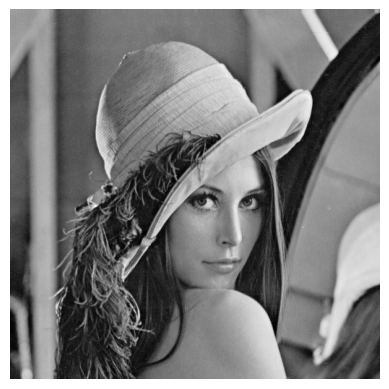

Pixel data saved to output_pixels.txt


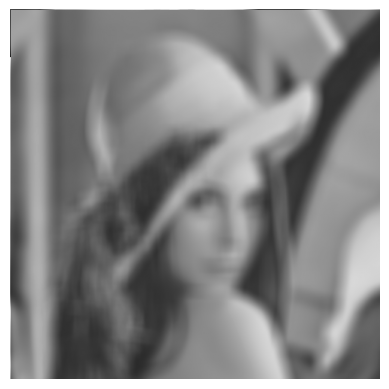

********** INTEGRAL IMAGE ALGO IN PYTHON ******************



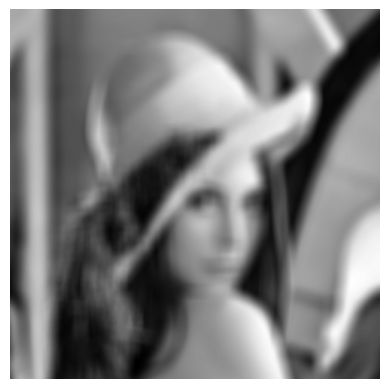

********** FPGA SIMULATION RESULT ************************ 



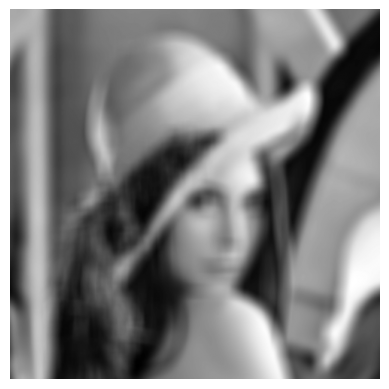

In [75]:


print("********** ORIGINAL IMAGE ******************\n")
img = process_image("lenna.png", "output_pixels.txt")

window_size=21

hei, wei = img.shape

yar = np.zeros((hei, wei))
temp = np.zeros((hei, wei))
box = np.zeros((hei,wei))

r = int((window_size-1)/2)
box = boxfilter(img,r)

##box_image = (box / window_size**2).astype(np.uint8)
box_print = box[r+1:hei-r+1,r+1:wei-r+1].astype(np.uint8)
plt.imshow(box_print, cmap="gray")

plt.axis("off")

plt.show()


yar[:window_size-1, :] = compute_integral_image(img[:window_size-1, :])


for i in range(hei - window_size + 1):
    temp = compute_integral_image(img[i:, :])
    yar[i+window_size-1, :] = temp[window_size-1, :] 


final_result = np.zeros((hei-window_size+1,wei-window_size+1))
sub_size_hei,sub_size_wei = final_result.shape

for row in range(sub_size_hei):  # Iterate over each row in `yar`
    for col in range(sub_size_wei):  # Iterate over each column
            final_result[row, col] = yar[row+window_size-1, col+window_size-1] - yar[row+window_size-1, col]





print("********** INTEGRAL IMAGE ALGO IN PYTHON ******************\n")           

normalized_img = normalize_and_display(final_result,window_size)

print("********** FPGA SIMULATION RESULT ************************ \n")
input_txt = "guided_filter.sim/sim_1/behav/xsim/yes.txt"
fpga_data = read_print_fpga(input_txt, 512,512,21)

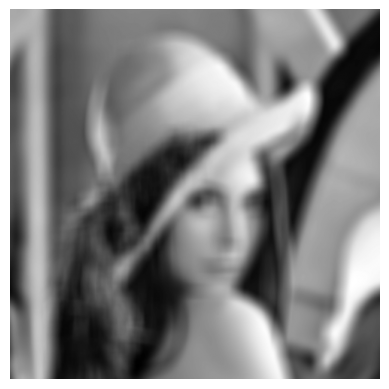

In [53]:


input_txt = "guided_filter.sim/sim_1/behav/xsim/yes.txt"
fpga_data = read_print_fpga(input_txt, 512,512,21)

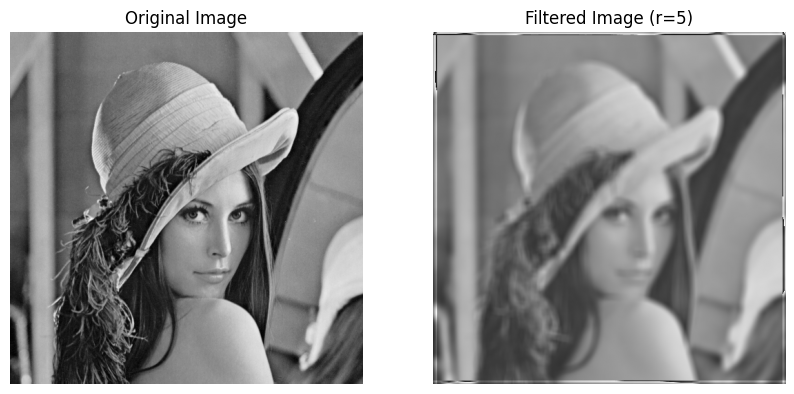

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the box filter function with normalization
def boxfilter(imSrc, r):
    hei, wid = imSrc.shape
    imDst = np.zeros_like(imSrc)

    # Cumulative sum over the Y axis
    imCum = np.cumsum(imSrc, axis=0)

    # Difference over the Y axis with normalization
    imDst[:r+1, :] = imCum[r:2*r+1, :] / (r+1)
    imDst[r+1:hei-r, :] = (imCum[2*r+1:hei, :] - imCum[:hei-2*r-1, :]) / (2*r+1)
    imDst[hei-r:, :] = (imCum[hei-1, :][None, :] - imCum[hei-2*r-1:hei-r-1, :]) / (r+1)

    # Cumulative sum over the X axis
    imCum = np.cumsum(imDst, axis=1)

    # Difference over the X axis with normalization
    imDst[:, :r+1] = imCum[:, r:2*r+1] / (r+1)
    imDst[:, r+1:wid-r] = (imCum[:, 2*r+1:wid] - imCum[:, :wid-2*r-1]) / (2*r+1)
    imDst[:, wid-r:] = (imCum[:, wid-1][:, None] - imCum[:, wid-2*r-1:wid-r-1]) / (r+1)

    return imDst

# Load the image (grayscale)
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)

# Apply the box filter with a radius of 5
radius = 5
filtered_image = boxfilter(image, radius)

# Display the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title(f"Filtered Image (r={radius})")
plt.axis('off')

plt.show()
